In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import random
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm,tqdm_notebook


In [2]:
print(f"Torch: {torch.__version__}")

Torch: 1.11.0+cu113


In [3]:
# Training settings
batch_size = 2
epochs = 50
lr = 3e-5
gamma = 0.7
seed = 42

image_size = 224


In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data stream

In [6]:
os.makedirs('data', exist_ok=True)
images_dir = 'images/images'
train_list = glob.glob(os.path.join(images_dir,'*/*.jpg'))
print(f"Number of total images: {len(train_list)}")

#split train and validation and test
train_list, test_list = train_test_split(train_list, test_size=0.1, random_state=seed)
train_list, val_list = train_test_split(train_list, test_size=0.1, random_state=seed)

print(f"Number of train images: {len(train_list)}")
print(f"Number of validation images: {len(val_list)}")
print(f"Number of test images: {len(test_list)}")

labels = [os.path.split(os.path.split(path)[0])[1] for path in train_list]
# kkep only unique labels
labels = list(set(labels))
print("The labels are:" ,labels)


Number of total images: 8446
Number of train images: 6840
Number of validation images: 761
Number of test images: 845
The labels are: ['Georges_Seurat', 'Edgar_Degas', 'Camille_Pissarro', 'Pierre-Auguste_Renoir', 'Salvador_Dali', 'Joan_Miro', 'Piet_Mondrian', 'Pablo_Picasso', 'Rembrandt', 'Paul_Cezanne', 'William_Turner', 'Vincent_van_Gogh', 'Paul_Klee', 'Albrecht_Durer', 'Edvard_Munch', 'Frida_Kahlo', 'Paul_Gauguin', 'Andrei_Rublev', 'Leonardo_da_Vinci', 'Pieter_Bruegel', 'Henri_de_Toulouse-Lautrec', 'Caravaggio', 'Kazimir_Malevich', 'Diego_Velazquez', 'Peter_Paul_Rubens', 'Vasiliy_Kandinskiy', 'Eugene_Delacroix', 'Sandro_Botticelli', 'Claude_Monet', 'Jackson_Pollock', 'Francisco_Goya', 'Edouard_Manet', 'Jan_van_Eyck', 'Andy_Warhol', 'Gustav_Klimt', 'Marc_Chagall', 'Gustave_Courbet', 'Giotto_di_Bondone', 'Amedeo_Modigliani', 'Titian', 'Henri_Rousseau', 'El_Greco', 'Henri_Matisse', 'Hieronymus_Bosch', 'Mikhail_Vrubel', 'Michelangelo', 'Raphael', 'Rene_Magritte', 'Alfred_Sisley', 'Diego

6840
[ 861 5391 5227 5192 3773 3093 5735 6266  467]


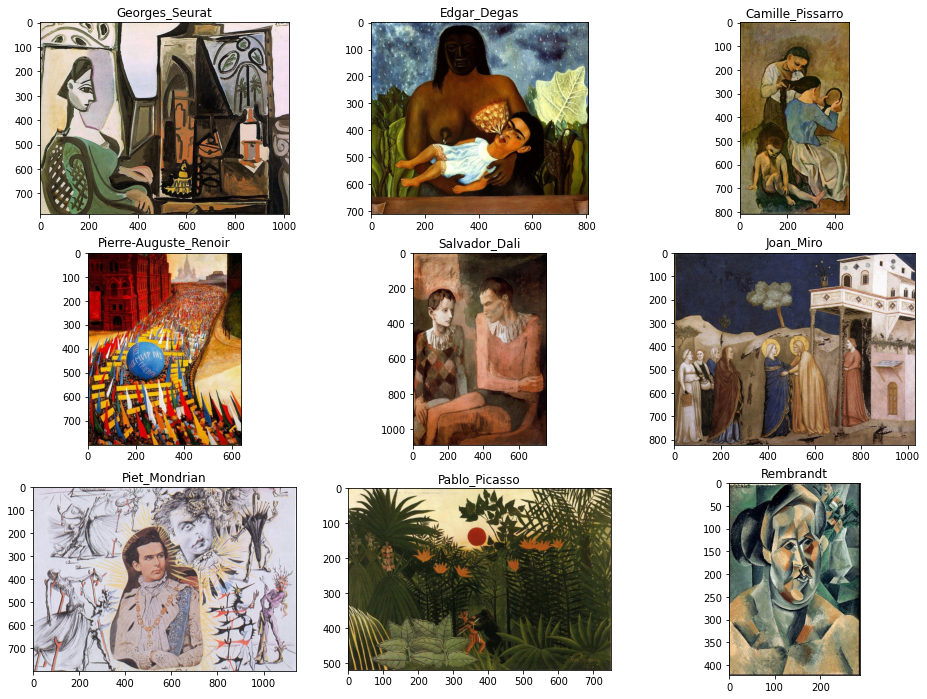

In [7]:
print(len(train_list))
random_idx = np.random.randint(1, len(train_list), size=9)
print(random_idx)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [8]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ]
)


In [9]:
class Create_dataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img = self.transform(img)
        # if the image is grayscale, convert it to rgb
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        label = os.path.split(os.path.split(img_path)[0])[1]
        # map label to index of labels
        label = labels.index(label)
        return img, label


In [10]:
# create dataset
train_dataset = Create_dataset(train_list, transform=train_transforms)
val_dataset = Create_dataset(val_list, transform=val_transforms)
test_dataset = Create_dataset(test_list, transform=test_transforms)

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# check the dataloader
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    print(target.shape)
    break

torch.Size([2, 3, 224, 224])
torch.Size([2])


In [11]:
# print the sizes of train, validation and test
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Train size: 6840
Validation size: 761
Test size: 845


In [12]:
torch.cuda.empty_cache()
# model
# import models from torchvision
import torchvision.models as models
model = models.resnet18(pretrained=True)
# freeze the model
for param in model.parameters():
    param.requires_grad = False
# change the last layer
model.fc = nn.Linear(512, len(labels))
model = model.to(device)


# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [13]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm_notebook(train_loader):

        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in tqdm_notebook(val_loader):
            
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(val_loader)
            epoch_val_loss += val_loss / len(val_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )
    #filename="./trained_models/pretrained_net"+str(epoch)+".pt"
    #torch.save(model.state_dict(), filename)

  0%|          | 0/3420 [00:00<?, ?it/s]

Epoch : 1 - loss : 3.6458 - acc: 0.1003 - val_loss : 3.5852 - val_acc: 0.1089



  0%|          | 0/3420 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print("Predictions: ")

for data, label in tqdm_notebook(test_loader):
        data = data.to(device)
        label = label.cpu()
        output = model(data).max(1).indices
        print("Predicticted: ",output, "  Label: ",label)